# DH22090004246 Submission for T51

In [294]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

import geopandas
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load UsArrests.csv data

In [295]:
task_df = pd.read_csv("UsArrests.csv",index_col='State')

## Exploring the data

Lets look at 10 random rows to guage what some of the data looks like

In [296]:
task_df.sample(10)

,Murder,Assault,UrbanPop,Rape
State,,,,
New York,11.100,254,86,26.100
Washington,4.000,145,73,26.200
Wyoming,6.800,161,60,15.600
Nebraska,4.300,102,62,16.500
Oklahoma,6.600,151,68,20.000
Iowa,2.200,56,57,11.300
Illinois,10.400,249,83,24.000
Connecticut,3.300,110,77,11.100
New Hampshire,2.100,57,56,9.500


These headings and index are clear to understand and interpret so do not require amending.

Lets review the shape of the data.

In [297]:
print(f'Number of Cities: {task_df.shape[0]}\nNumber of features: {task_df.shape[1]}')

Number of Cities: 50
Number of features: 4


This is a small data set so its important we check for missing data and handle carefully to enure we dont skew the results or mis interpret the data.

In [298]:
# Count missing values
missing = task_df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing


,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


There is no missing data which is great.

Lets summarise the statistical properties of the columns to see if any one feature stands out above the rest:

In [299]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = task_df.describe()
stats.loc['var'] = task_df.var().tolist()
selected_stats = stats.loc[["mean","std","var","min","max"]].transpose() #select relevant rows
display(selected_stats.style.background_gradient(cmap='Reds', subset=["mean","std","var","min","max"]).format(precision=2))

,mean,std,var,min,max
Murder,7.79,4.36,18.97,0.80,17.40
Assault,170.76,83.34,6945.17,45.00,337.00
UrbanPop,65.54,14.47,209.52,32.00,91.00
Rape,21.23,9.37,87.73,7.30,46.00


Looking at these values its clear that the differences in datas ranges means that the data would benefit from being scaled.

In [300]:
#  use StandardScaler to scale data
scaler = StandardScaler()
task_df = pd.DataFrame(scaler.fit_transform(task_df), index = task_df.index, columns = task_df.columns)

In [301]:
# Lets Check the output now
stats = task_df.describe()
stats.loc['var'] = task_df.var().tolist()
selected_stats = stats.loc[["mean","std","var","min","max"]].transpose() #select relevant rows
display(selected_stats.style.background_gradient(cmap='Greens', subset=["mean","std","var","min","max"]).format(precision=2))

,mean,std,var,min,max
Murder,-0.00,1.01,1.02,-1.62,2.23
Assault,0.00,1.01,1.02,-1.52,2.02
UrbanPop,-0.00,1.01,1.02,-2.34,1.78
Rape,0.00,1.01,1.02,-1.50,2.67


Much easier to cross reference now given they are scaled.

Lets check the type of each variable

In [302]:
# Examine types
task_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     float64
 2   UrbanPop  50 non-null     float64
 3   Rape      50 non-null     float64
dtypes: float64(4)
memory usage: 2.0+ KB


We are working with continuous data and the data is already in the right data type.

## Visualise the Distribution of the Observations

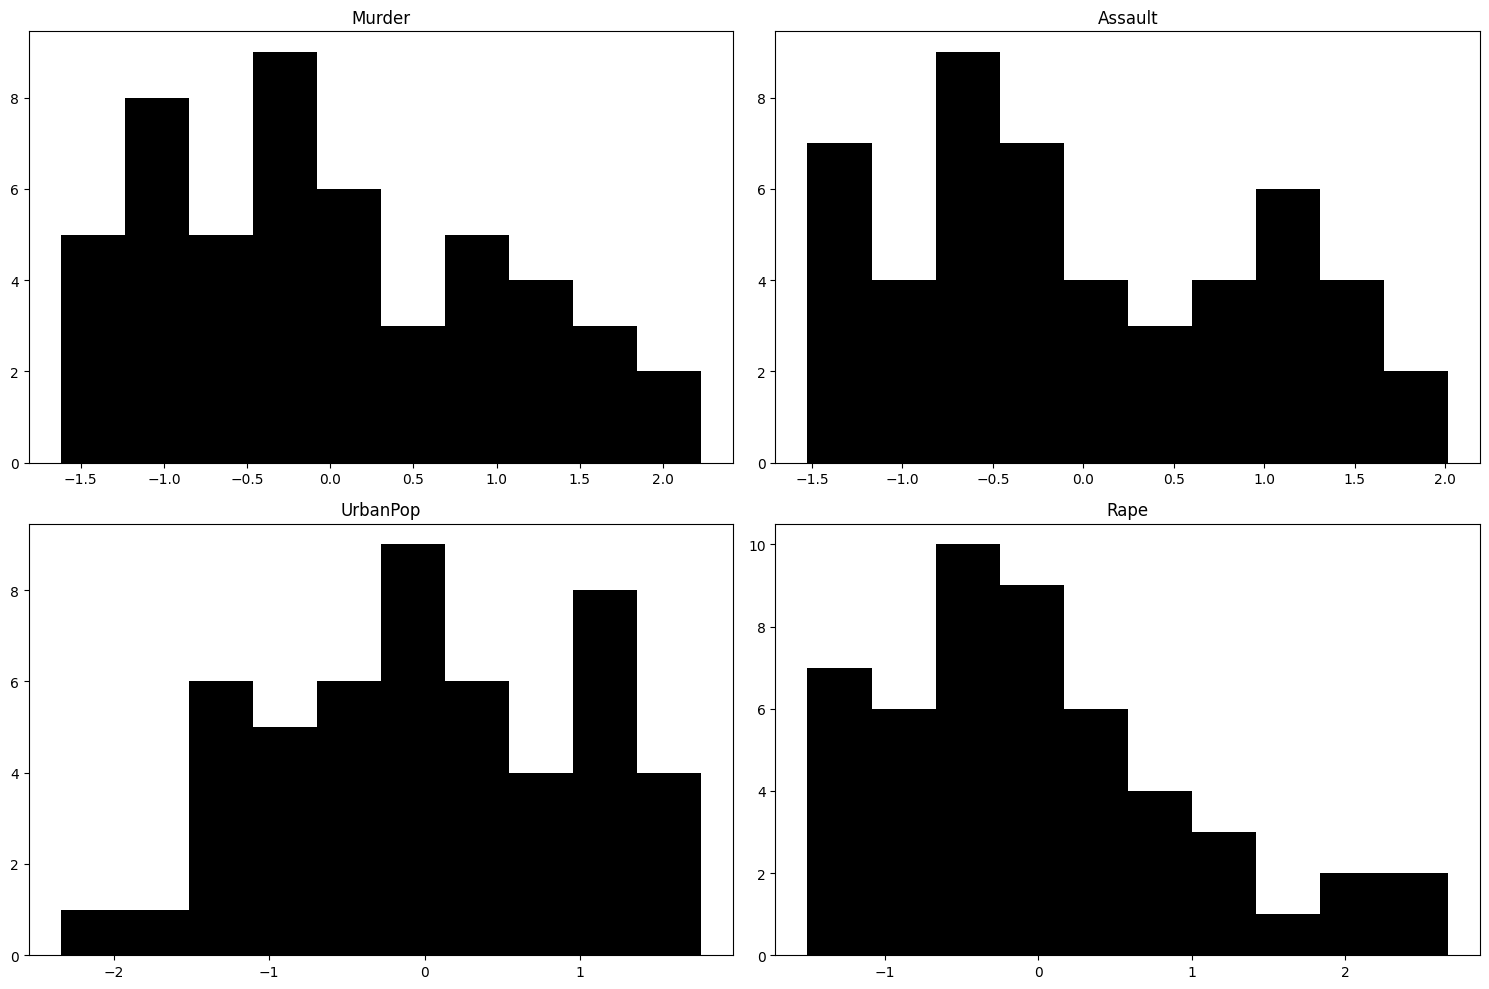

In [303]:
# Plot histograms
histograms = task_df.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()


The data is clear, checked and in good order reday to proceed with Analysis - with pretty even distributions of rape and assualt and inverse distributions of urbanpop and rape. Lets see how these data sets actually correlate.

## Correlation Analysis

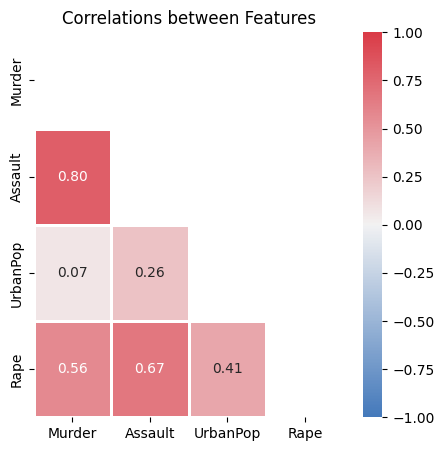

In [304]:
cities = task_df.index
labels = task_df.columns
# colormap = "coolwarm"
colormap = sns.diverging_palette(250, 10, as_cmap=True)

# get correlations
corrs = task_df.corr()

# pick appropriate palette for heatmap

# Plot figsize
fig, ax = plt.subplots(figsize=(5, 5))

# to mask mirrored side of heatmap
dropSelf = np.zeros_like(corrs)
dropSelf[np.triu_indices_from(dropSelf)] = True

# Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2,vmax=1,vmin=-1)
plt.title("Correlations between Features")

plt.show()

In the plot, there is a linear correlation between strongly correlated variables: those coloured in either dark red or dark blue. Variables which are positively correlated are red: an increase in one corresponds to an increase in the other, while negatively correlated variables are blue: a decrease in one means an increase in the other. The closer to white, the closer to no correlation between the variables.

Looking at the heatmap of the correlation data one can see that there are no blue plots at all showing that there are no negatively correlating features in this data set - meaning that as one feature increases in general the others do too to some degree given they all show some positive correlation.

The Highest Correlation of features is between Murder and Assault - i.e the higher the Murder figures the higher the Assualt figures. However the highest genreal correlation to the other features is Rape and the lowest is Urban Population.

There may be some redundancy in teh data which can be identified doing a PCA Analysis.

## PCA Analysis

Principal Components Analysis (PCA) is a method for finding the underlying variables (i.e. principal components) that best differentiate the observations by determining the directions along which your data points are most spread out. Since the determination of the principal components is based on finding the direction that maximises the variance, variables with variance that are much higher than the other variables tend to dominate the analysis purely due to their scale. PCA is a dimensionality reduction techinque which is useful when we have a lot of variables, and need to reduce these. 



In [305]:
# Fit the PCA model and transform X to get the principal components
np.set_printoptions(precision=2)
pca = PCA()
task_df_pca = pd.DataFrame(pca.fit_transform(task_df), columns=['PC1', 'PC2', 'PC3', 'PC4'], index=task_df.index)
task_df_pca.head(10)

,PC1,PC2,PC3,PC4
State,,,,
Alabama,0.99,1.13,-0.44,0.16
Alaska,1.95,1.07,2.04,-0.44
Arizona,1.76,-0.75,0.05,-0.83
Arkansas,-0.14,1.12,0.11,-0.18
California,2.52,-1.54,0.60,-0.34
Colorado,1.51,-0.99,1.10,0.00
Connecticut,-1.36,-1.09,-0.64,-0.12
Delaware,0.05,-0.33,-0.72,-0.88
Florida,3.01,0.04,-0.58,-0.10


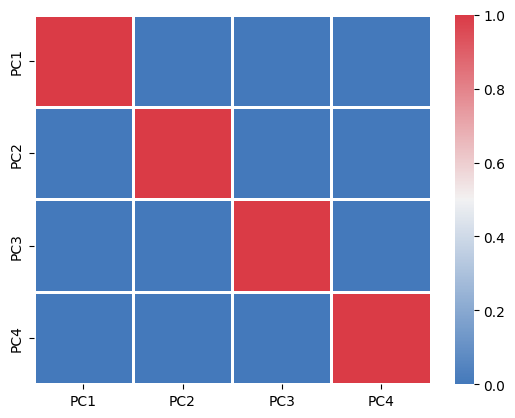

In [306]:
# plotting the transformed version of the data
ax = sns.heatmap(task_df_pca.corr(), cmap=colormap,linewidth=1)
plt.show()

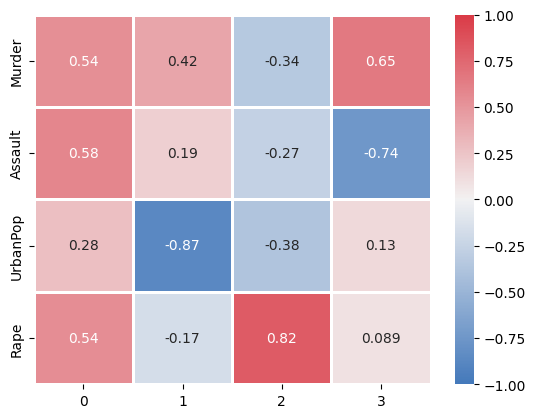

In [307]:
components = pd.DataFrame(pca.components_, columns=task_df.columns).transpose()
ax = sns.heatmap(components,cmap=colormap,linewidth=1, annot=True,vmax=1,vmin=-1)
plt.show()

Lets review the resulting statistics.

In [308]:
Results = pd.DataFrame(columns = task_df_pca.columns)
# Standard deviation of each principal
Results = pd.concat([Results,pd.DataFrame(np.sqrt(pca.explained_variance_),
                                      index = task_df_pca.columns, columns = ['Standard Deviation']).T])
# The variance explained by each principal component
Results = pd.concat([Results,pd.DataFrame(pca.explained_variance_, index = task_df_pca.columns, columns = ['Explained Variance']).T])
# Explained variance ratio each principal
Results = pd.concat([Results,pd.DataFrame(pca.explained_variance_ratio_,
                                      index = task_df_pca.columns, columns = ['Proportion of Variance']).T])
# Cumulative Proportion
Results = pd.concat([Results,pd.DataFrame(np.cumsum(pca.explained_variance_ratio_),
                                      index = task_df_pca.columns, columns = ['Cumulative Proportion']).T])
display(Results.style.format(precision=4))

,PC1,PC2,PC3,PC4
Standard Deviation,1.5909,1.0050,0.6032,0.4207
Explained Variance,2.5309,1.0100,0.3638,0.1770
Proportion of Variance,0.6201,0.2474,0.0891,0.0434
Cumulative Proportion,0.6201,0.8675,0.9566,1.0000


62% of the Variance is coming from PC1 alone lets graph this to see the make up easier.


([<matplotlib.axis.XTick at 0x28daa41c0>,
 [Text(1, 0, 'PC1'), Text(2, 0, 'PC2'), Text(3, 0, 'PC3'), Text(4, 0, 'PC4')])

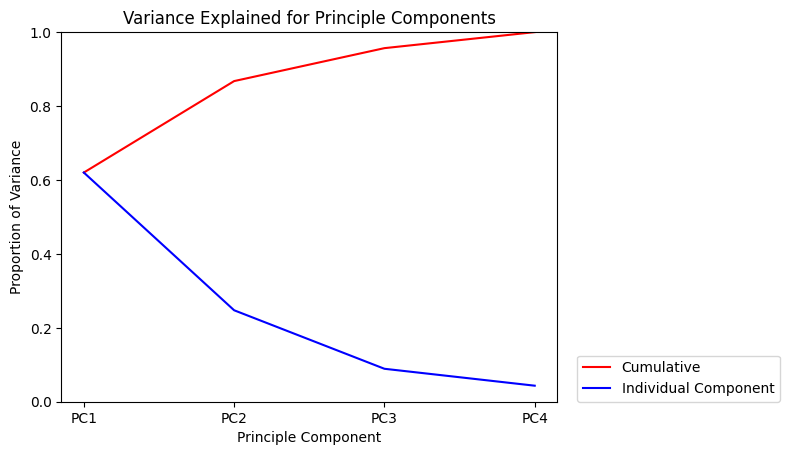

In [309]:
# Cumulative variance plot
plt.ylabel('Proportion of Variance')
plt.xlabel('Principle Component')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label = 'Cumulative')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         pca.explained_variance_ratio_,
         c='blue',
         label = 'Individual Component')
plt.ylim(0,1)
plt.title("Variance Explained for Principle Components")
plt.legend(loc=(1.04,0))
plt.xticks(range(1,len(task_df_pca.columns)+1),labels=task_df_pca.columns,rotation=0)

The Red 'Cumulative' Line shows the cumulative proportion of variance explained by the four principal components.

The Blue 'Individual Component' Line: is also know as the a scree plot depicts the proportion of variance explained by each of the principal components individually.

The first 2 principal components together explain over 86% of the variance, therefore we can use them to perform cluster analysis. This is referred to as dimensionality reduction - started with 4 but can use 2 features as they explain most of the variability.


In [310]:
# Remove the PC3 and PC4 as pre the PCA analysis
pca_task_df = pd.DataFrame(task_df_pca.iloc[:,0:2], index = task_df.index)
pca_task_df.head()

,PC1,PC2
State,,
Alabama,0.99,1.13
Alaska,1.95,1.07
Arizona,1.76,-0.75
Arkansas,-0.14,1.12
California,2.52,-1.54


## Lets plot a BiPlot of the Projected Observations

In [311]:
# lets get the max and min vlaues of PC1 and PC2 to help set the x/y axis limits
pca_task_df.max()

PC1   3.01
PC2   2.39
dtype: float64

In [312]:
pca_task_df.min()

PC1   -2.99
PC2   -1.57
dtype: float64

The range of data can be caught between 3.5 to -3.5.

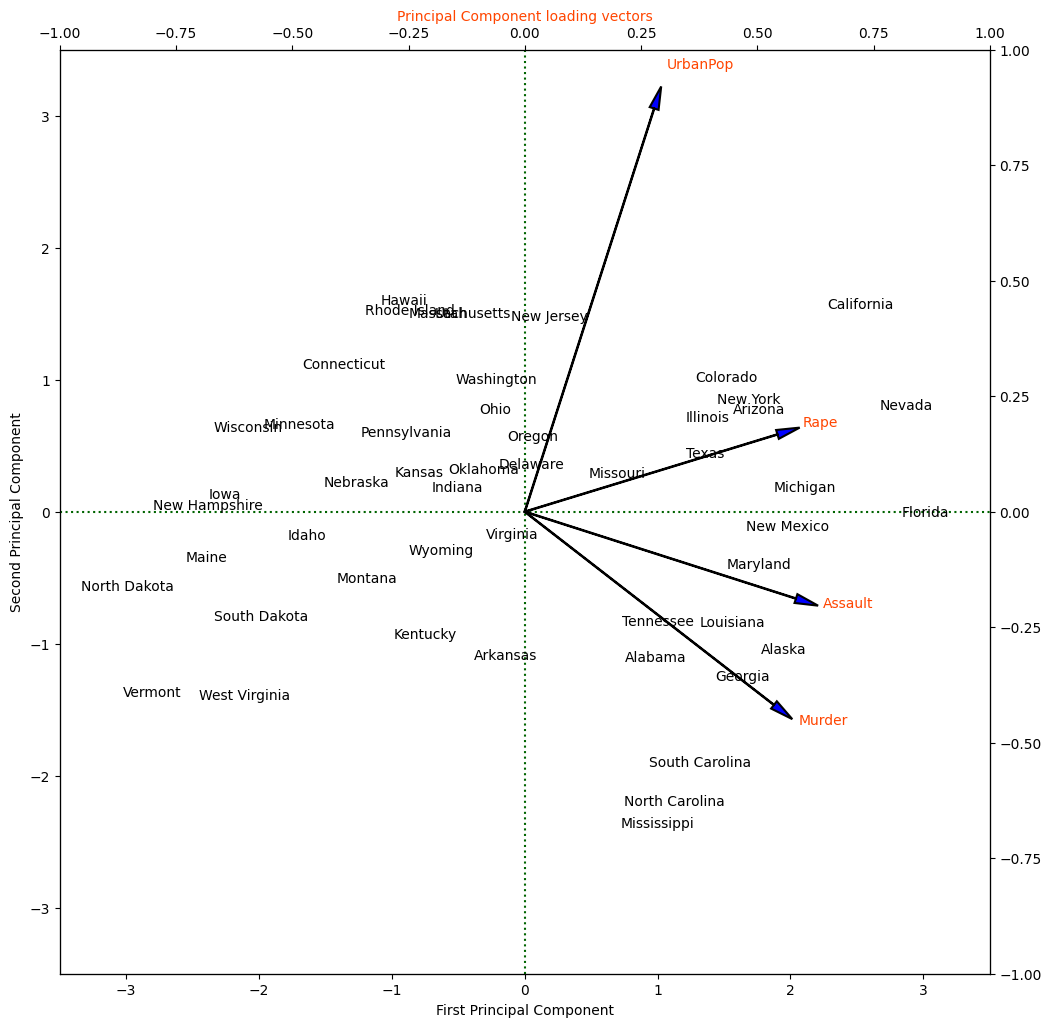

In [313]:
# get the loading vectors
pca_loadings = pd.DataFrame(PCA().fit(task_df).components_.T, index=task_df.columns, columns=['V1', 'V2', 'V3', 'V4'])

fig , ax = plt.subplots(figsize=(12,12))
ax.set_xlim(-3.5,3.5)
ax.set_ylim(-3.5,3.5)

# Plot Principal Components 1 and 2
for i in task_df_pca.index:
    ax.annotate(i, (task_df_pca.PC1.loc[i], -task_df_pca.PC2.loc[i]), ha='center')
    
# Plot reference lines
ax.hlines(0,-3.5,3.5, lw = 1.5, linestyles='dotted', colors='DarkGreen')
ax.vlines(0,-3.5,3.5, lw = 1.5, linestyles='dotted', colors='DarkGreen')

ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')

# Creating a a second y-axis for Principal Component loading vectors Plot
ax1 = ax.twinx().twiny()
ax1.set_ylim(-1,1)
ax1.set_xlim(-1,1)
ax1.tick_params(axis='y', colors='orange')
ax1.set_xlabel('Principal Component loading vectors', color='OrangeRed')

a = 1.1  
for i in pca_loadings[['V1', 'V2']].index:
    ax1.annotate(i, (pca_loadings.V1.loc[i]*a, -pca_loadings.V2.loc[i]*a), color='OrangeRed')
    
# Plot vectors
for i in range(len(pca_loadings.index)):
    ax1.arrow(0,0, pca_loadings.V1[i], -pca_loadings.V2[i], head_width=0.02, head_length=0.05, lw = 1.5, fc='Blue', ec='k')

Each point on a biplot is the projected observation, transformed from the original data. The importance of each feature is indicated by the length of the arrows on the biplot. This corresponds to the magnitude of the values in the eigenvectors. From this biplot, we see that UrbanPop is the most important feature in teh direciton of PC2 as the arrow is the longest with Assualte and Muder looking like them just hold more importance than rape and for PC1 but all three are in a clear second tier to the importance of urban population.

HOwever lets choeck the data closer...

In [314]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_task_df = pd.DataFrame()
feat_task_df["Features"] = list(labels)
feat_task_df["PC1 Importance"] = pc1
feat_task_df["PC2 Importance"] = pc2
feat_task_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Several features are important for the first component with Assualt leading the way marginally whilst UrbanPop has by far the highest importance in the second principle component and murder following behind but clearly ahead of Assulat and Rape. These observations agree with those deduced from the biplot.

Let us review the datas make and see how these fetures overlap and what clusters can be identified, if any.

## Hierarchical clustering


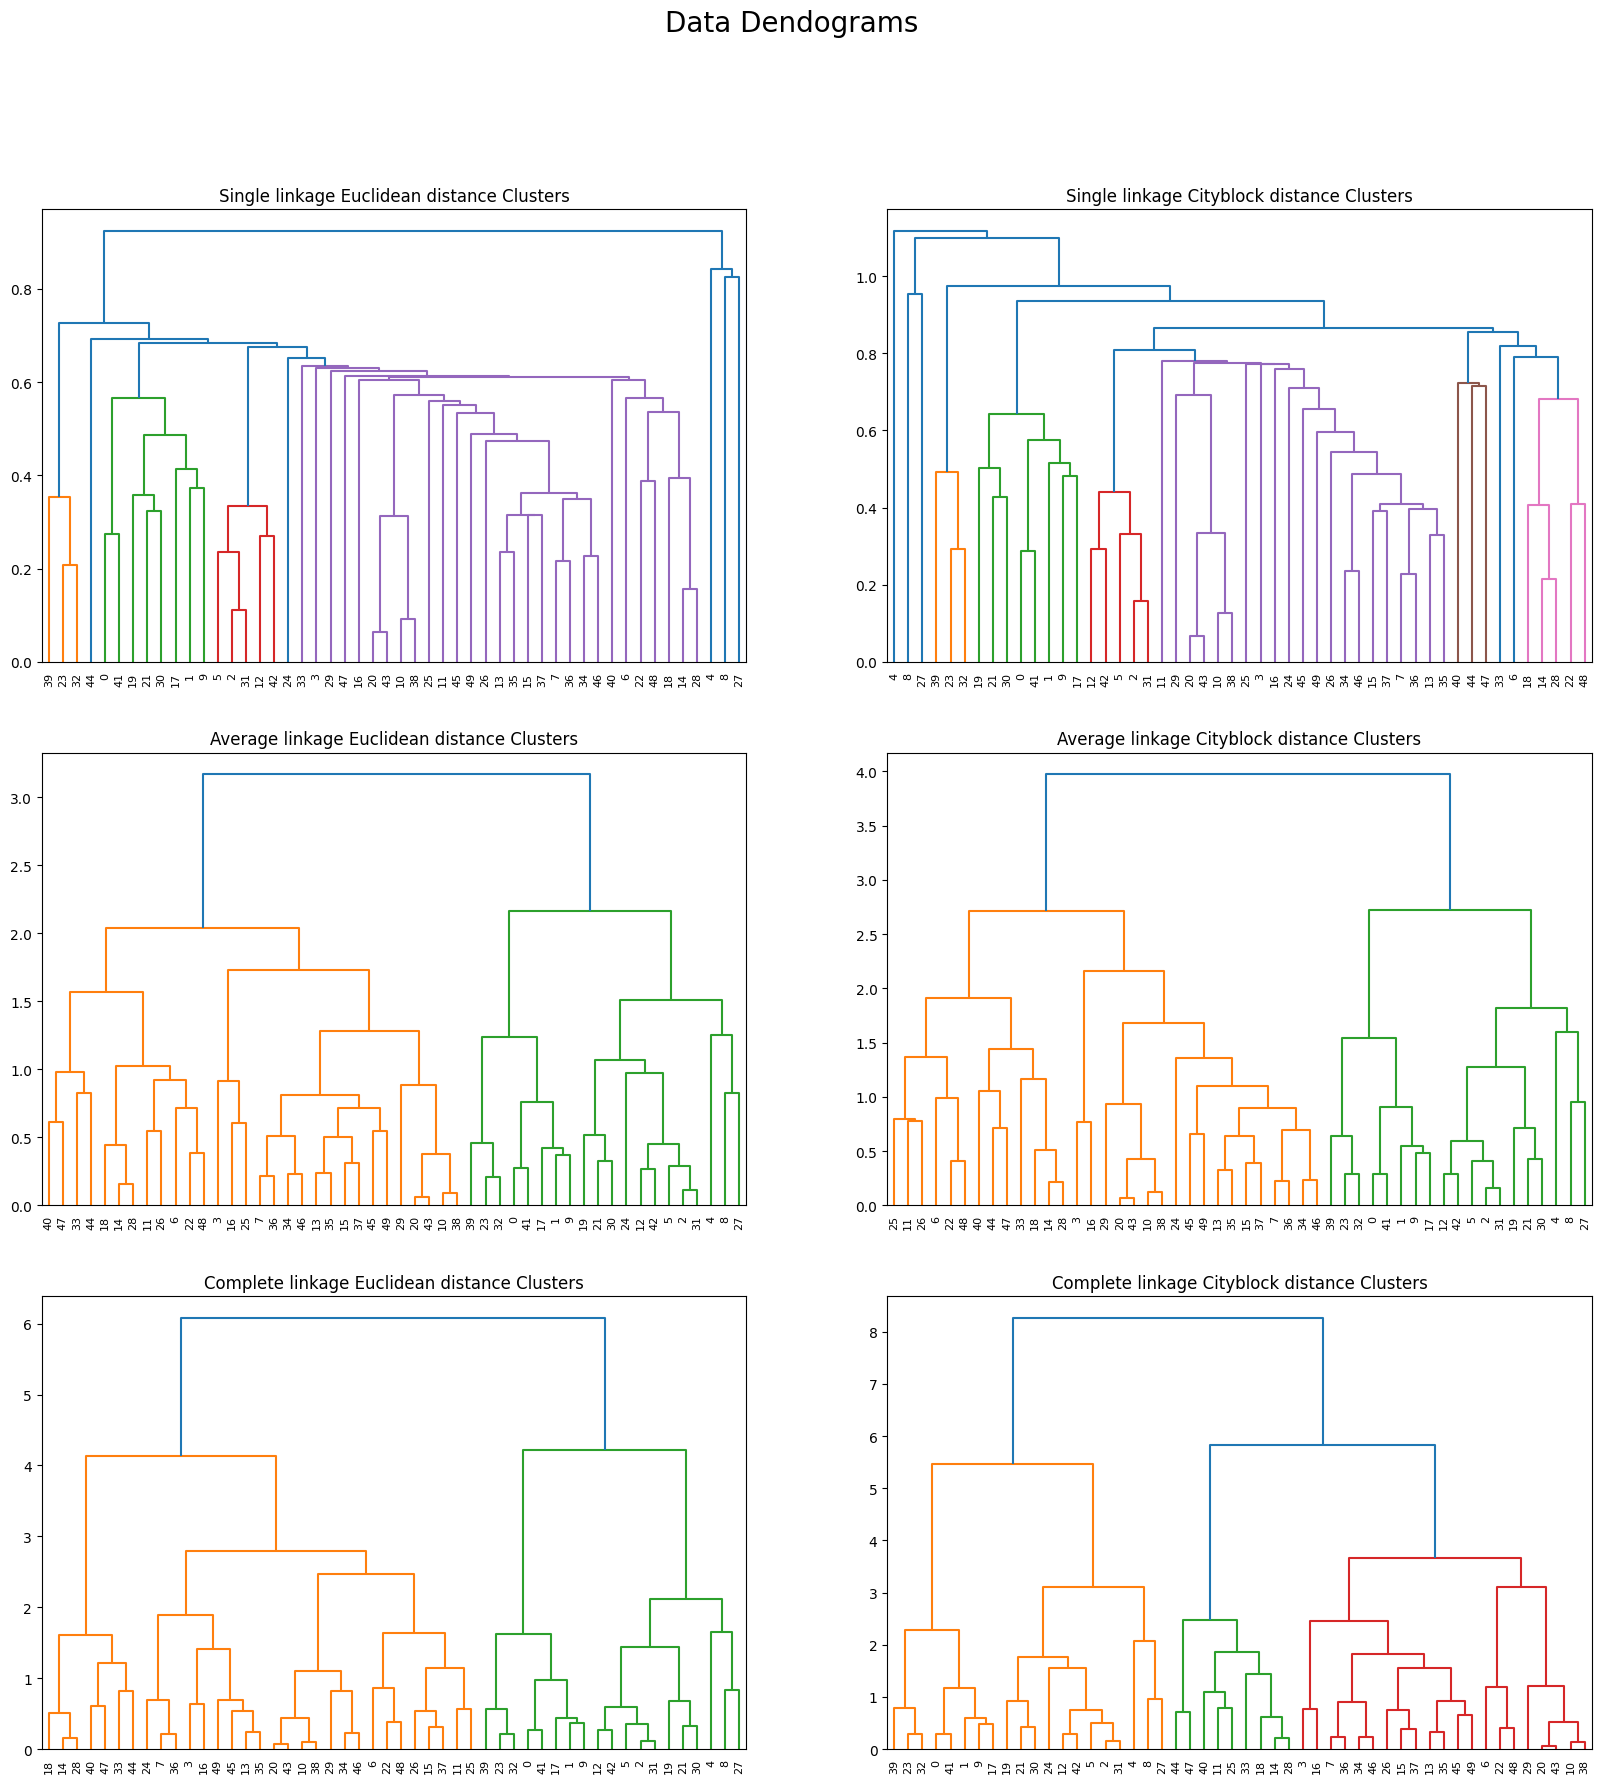

In [315]:
# create figure of 6 combinations of linkage and metric
plt.figure(figsize=[20,20])
plt.suptitle("Data Dendograms", fontsize=20)  
linkage_types = ['single', 'average', 'complete']
affinity_types = ['euclidean', 'cityblock']
grid_id = 1
for linkage_type in linkage_types:
    for affinity_type in affinity_types:
        plt.subplot(3, 2, grid_id)
        
        ax = dendrogram(linkage(pdist(pca_task_df, affinity_type), method=linkage_type))  
                
        plt.title(f'{linkage_type.title()} linkage {affinity_type.title()} distance Clusters')
        
        grid_id += 1

## Review the dendrograms

Reviewing the dendrograms the variances in the simple linkage models are so close its only safe to say there is 1 cluster (at most 2). The Average Linkage suggests 2 clusters or possibly 4 (and at a push 6). Finally the complete linkage models the number could be 4 (marginally 6/7). The cityblock metric showing a clearer split of the clusters.

Given its clearer display of clusters I belive its best to proceed with the **Complete linkage with Cityblock metric** combination and suggest (given the above) the best fixed number of clusters to proceed with is 4.

Text(0.5, 0.98, 'Final Dendogram: Complete linkage Cityblock distance Clusters')

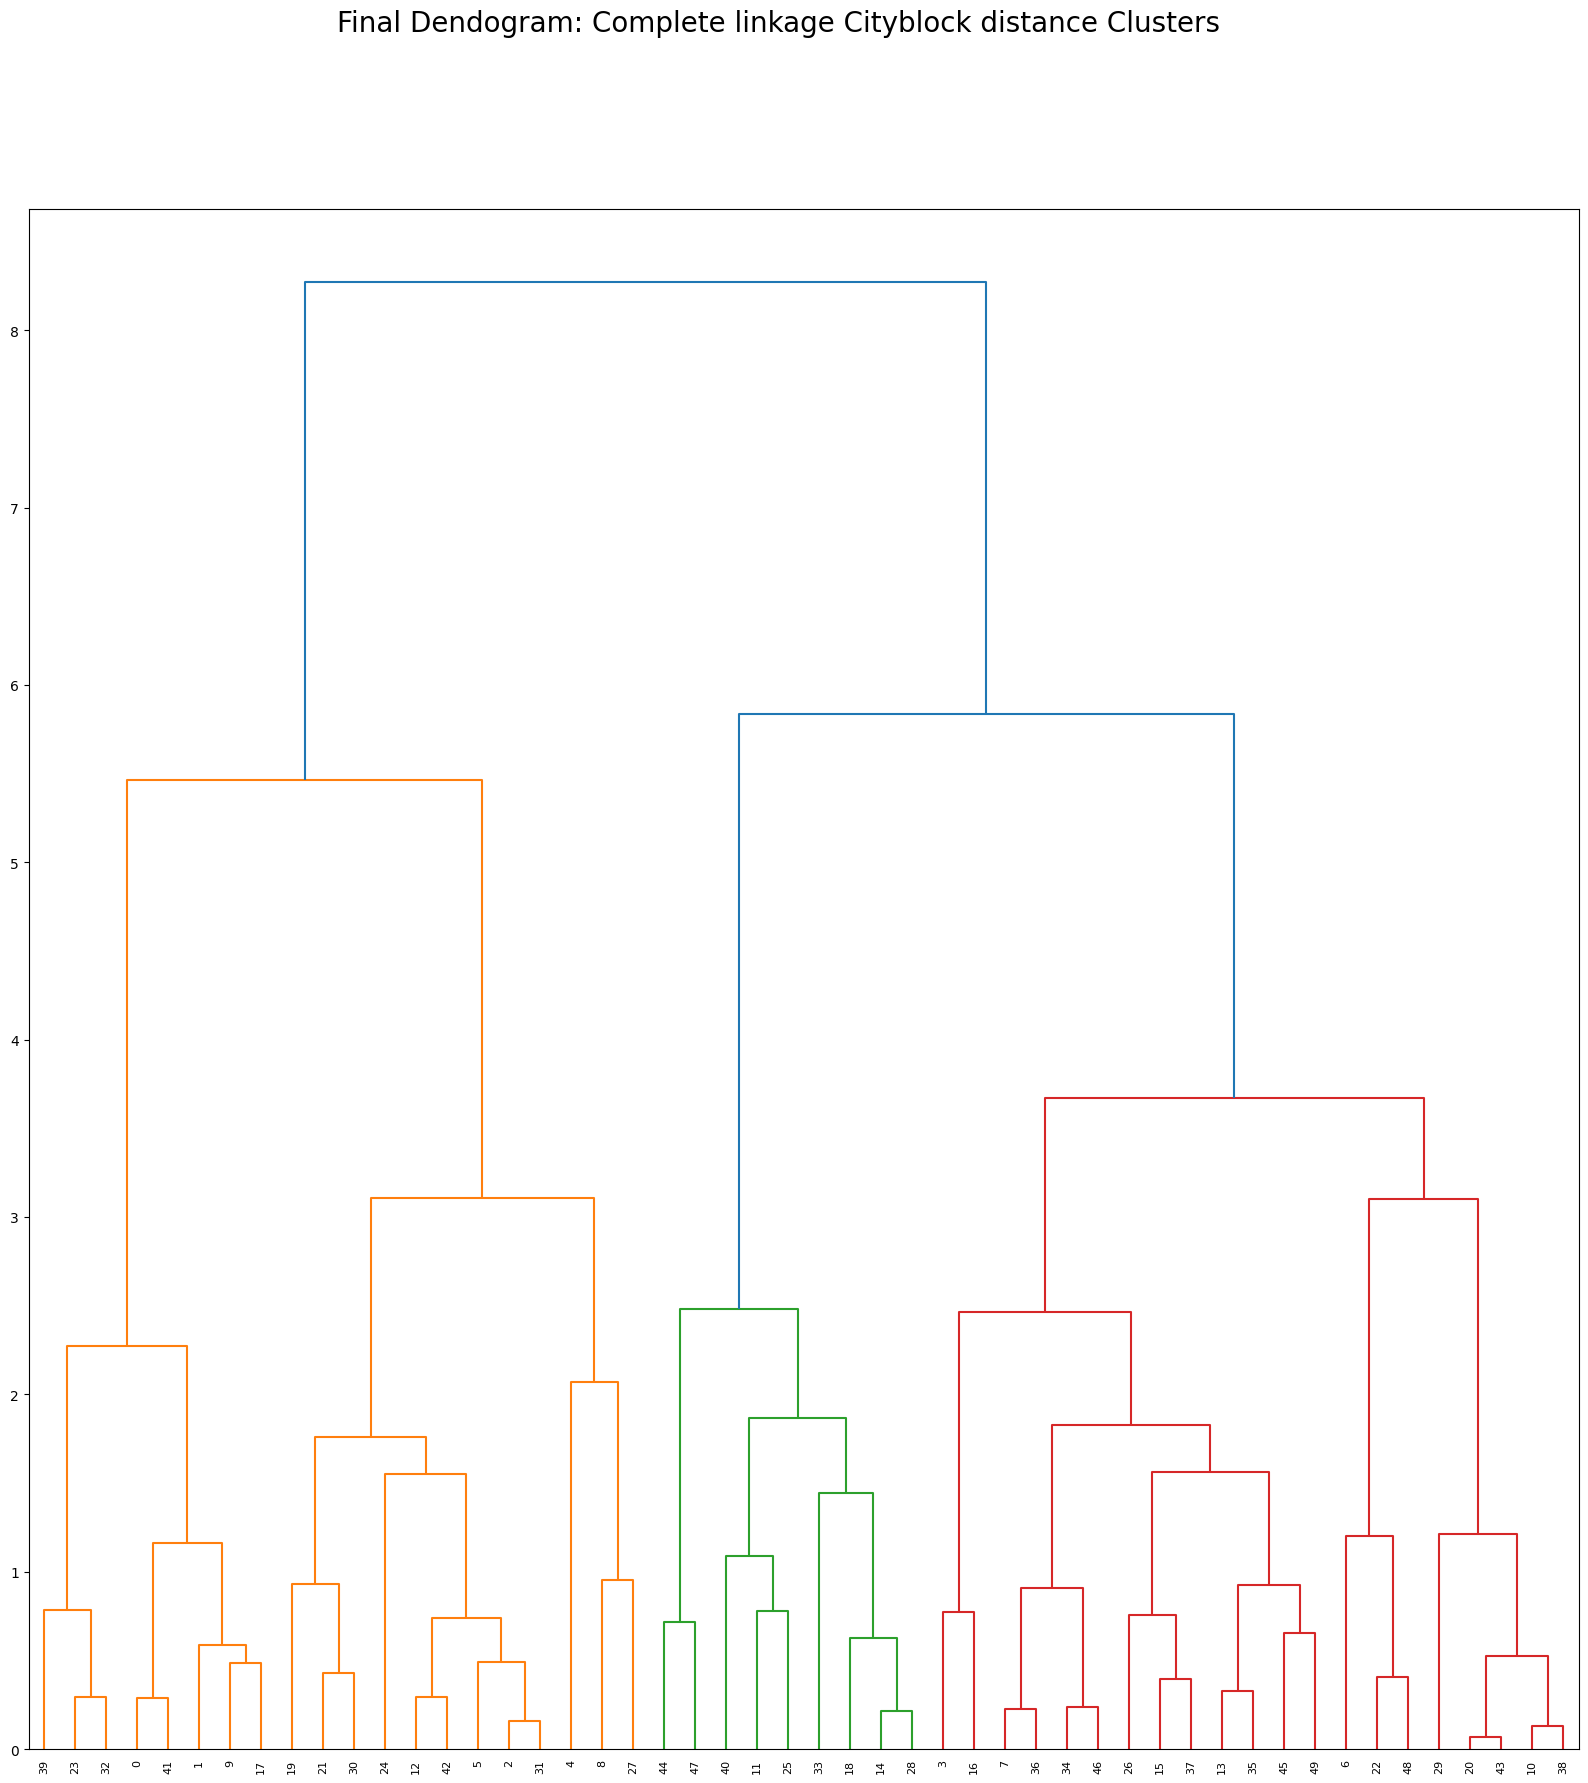

In [316]:
# create figure of chosen plot
plt.figure(figsize=[20,20])
ax = dendrogram(linkage(pdist(pca_task_df, 'cityblock'), method='complete'))  
plt.suptitle('Final Dendogram: Complete linkage Cityblock distance Clusters', fontsize=20)

## Run an agglomerative hierchical clustering with these chosen combinations to See the results

Text(0, 0.5, 'Dim 1')

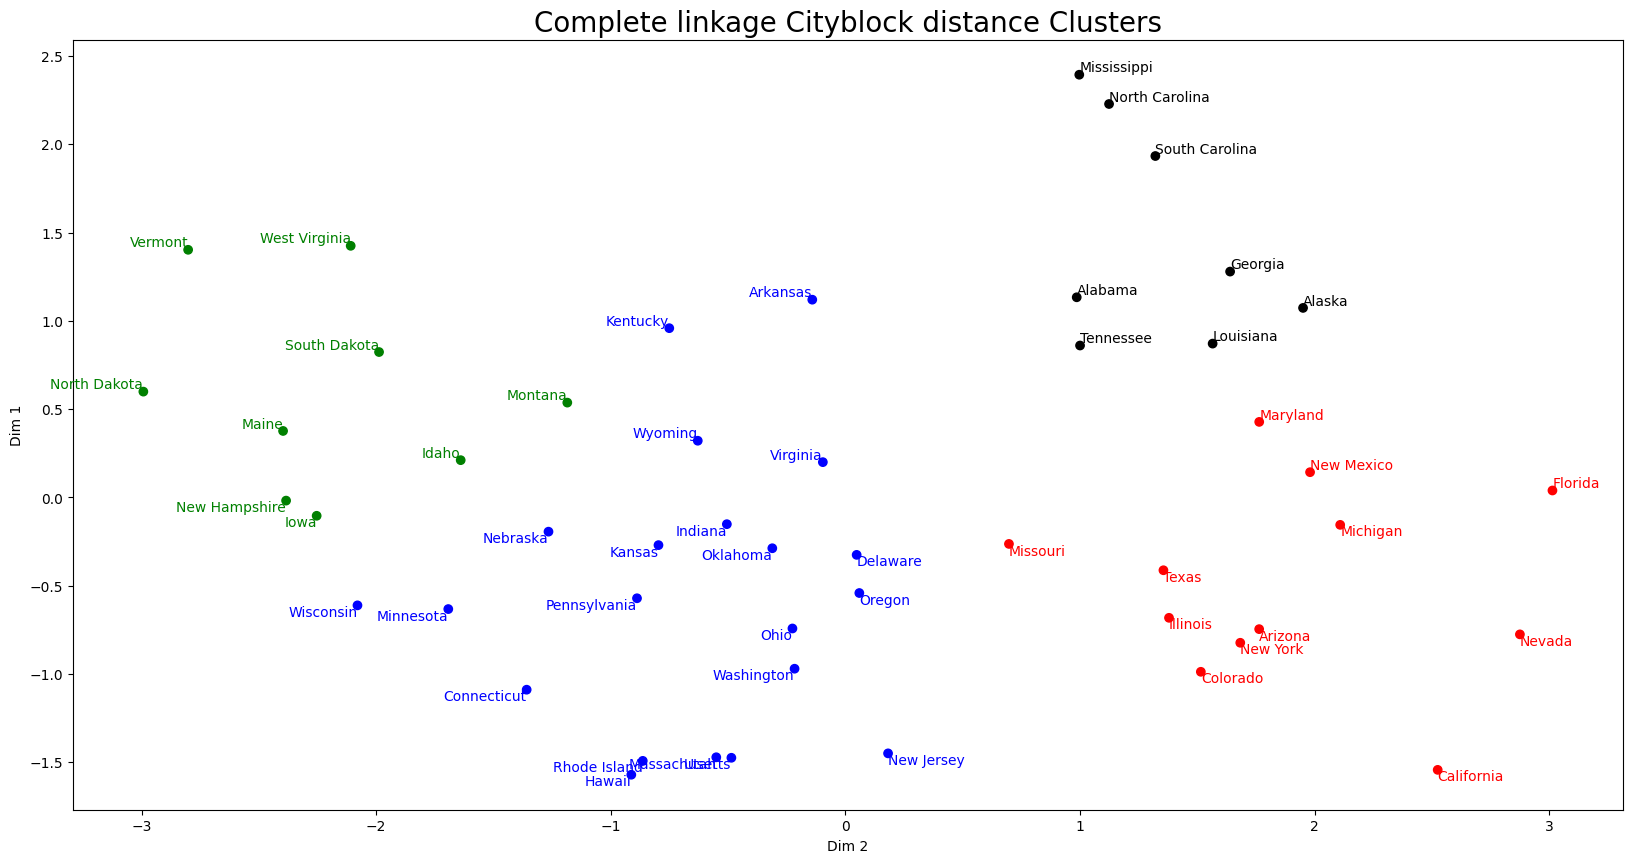

In [317]:
# chosen combinations
linkage_type = 'complete'
affinity_type = 'cityblock'
n_cluster = 4

plt.figure(figsize=[20,10])
cluster = AgglomerativeClustering(n_clusters=n_cluster, metric=affinity_type, linkage=linkage_type)
cluster.fit_predict(pca_task_df)

# create cmap to share with annotation
colours_dict = {}
colour_options = ['Blue','Red','Green','black','orange','pink'] # created 6 incase more clusters identified
for i,colour_option in enumerate(colour_options):
    colours_dict[i] = colour_option

ax = plt.scatter(pca_task_df.iloc[:,0], pca_task_df.iloc[:,1], c=pd.DataFrame(cluster.labels_)[0].map(colours_dict))
plt.title(f'{linkage_type.title()} linkage {affinity_type.title()} distance Clusters', fontsize=20)
for i in range(len(pca_task_df.index)):
    ha_value = 'left' if pca_task_df.iloc[:,0][i] > 0 else 'right'
    va_value = 'bottom' if pca_task_df.iloc[:,1][i] > 0 else 'top' 
    plt.annotate(pca_task_df.index[i], (pca_task_df.iloc[:,0][i], pca_task_df.iloc[:,1][i]), ha=ha_value, va=va_value, c=colours_dict[cluster.labels_[i]])
    
plt.xlabel("Dim 2")
plt.ylabel("Dim 1")

These clusters are clear to me but for Kentucky and Arkansas which might suggest there's more information to be found. Lets run a K-means analysis to see.

## K-Means Cluster Analysis

K-means is a very popular clustering partitioning algorithm that is fast and efficient and scales well for large datasets. It is an iterative process, so observations can switch between clusters while the algorithm runs until it converges at a local optimum. This method is not robust when it comes to noise data and outliers and is not suitable for clusters with non-convex shapes. Another drawback with K-means is the necessity of specifying K in advance.

To begin with A K value of 4 will be set.


In [318]:
km_model = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
km_model.fit(pca_task_df)
pd.Series(km_model.labels_).value_counts(sort = False).to_frame('Count').T

,2,0,3,1
Count,9,11,17,13


Lets run a range of K vlaues to see the results and form a visualisation of the resulting clusters

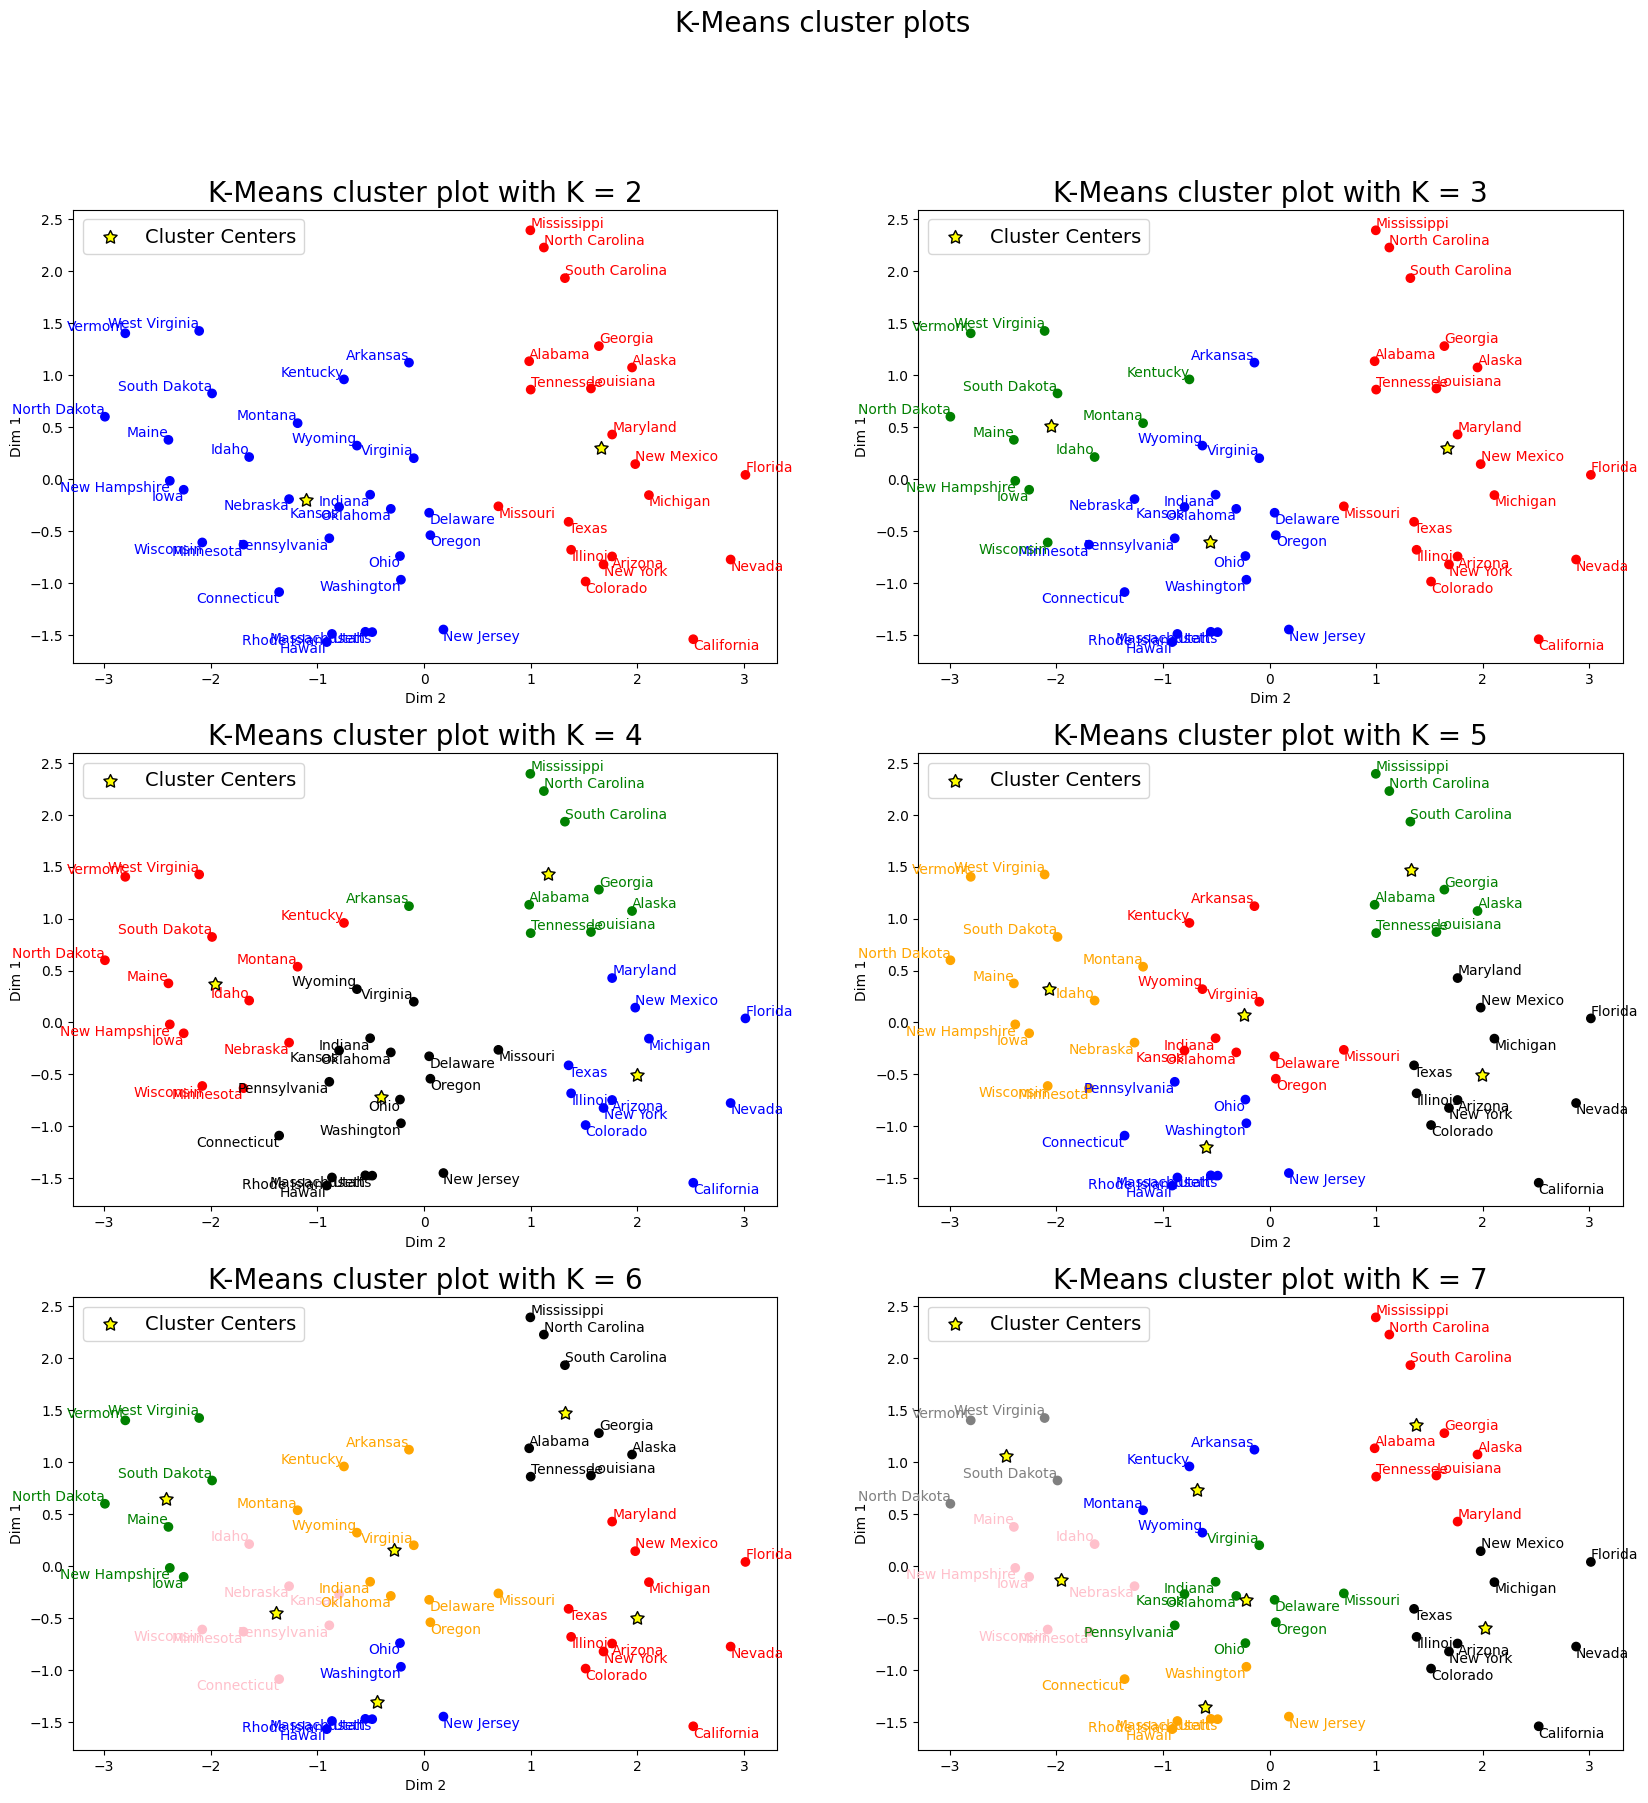

In [319]:
# Create list of K-Values to test
k_vlaues = [2,3,4,5,6,7]

# create lists to collect performance results
silhouette_avg = []
Sum_of_squared_distances = []

# create dictionary to catch clusters
clusters_dict = {}

# create cmap to share with annotation
colours_dict = {}
colour_options = ['Blue','Red','Green','Black','Orange','Pink','Grey']
for i,colour_option in enumerate(colour_options):
    colours_dict[i] = colour_option

# create figure of all 6 combinations
plt.figure(figsize=[20,20])
plt.suptitle("K-Means cluster plots", fontsize=20)  
grid_id = 1
for k in k_vlaues:
    cluster_dict = {}
    
    plt.subplot(3, 2, grid_id)

    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10) # n_init set to 10 which is the default of kMeans but needs to be explicitly set since 1.4
    cluster_labels = kmeans.fit_predict(pca_task_df)
    Sum_of_squared_distances.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(pca_task_df, cluster_labels))
    
    cent = kmeans.cluster_centers_
    
    ax = plt.scatter(pca_task_df.iloc[:,0], pca_task_df.iloc[:,1], c=pd.DataFrame(cluster_labels)[0].map(colours_dict))
    ax= plt.scatter(cent[:,0], cent[:,1], marker=(5, 1), facecolors= 'Yellow', edgecolor = 'Black',
                   s=100, linewidths=1, label  = 'Cluster Centers')
    plt.title(f"K-Means cluster plot with K = {k}", fontsize=20)
    for i in range(len(pca_task_df.index)):
        ha_value = 'left' if pca_task_df.iloc[:,0][i] > 0 else 'right'
        va_value = 'bottom' if pca_task_df.iloc[:,1][i] > 0 else 'top' 
        plt.annotate(pca_task_df.index[i], (pca_task_df.iloc[:,0][i], pca_task_df.iloc[:,1][i]), ha=ha_value, va=va_value, c=colours_dict[cluster_labels[i]])
    ax = plt.legend(loc='upper left', fontsize = 14, frameon=True)    
    plt.xlabel("Dim 2")
    plt.ylabel("Dim 1")
    
    # add info to cluster_dict
    for i in range(1,k+1):
        cluster_dict[i] = pca_task_df[cluster_labels == i-1].index.tolist()
    
    clusters_dict[k] = cluster_dict
    
    grid_id +=1

Looking at these clusters by varying the k value, its clear scaling the data and running the PCA analysis has clearly given the K-Means modelling the best chance of finding clear and distinct clusters.

From analysising these different plots it would seem K values from 4 to 7 look resonably plausible groups of clusters. However lets check their performance.

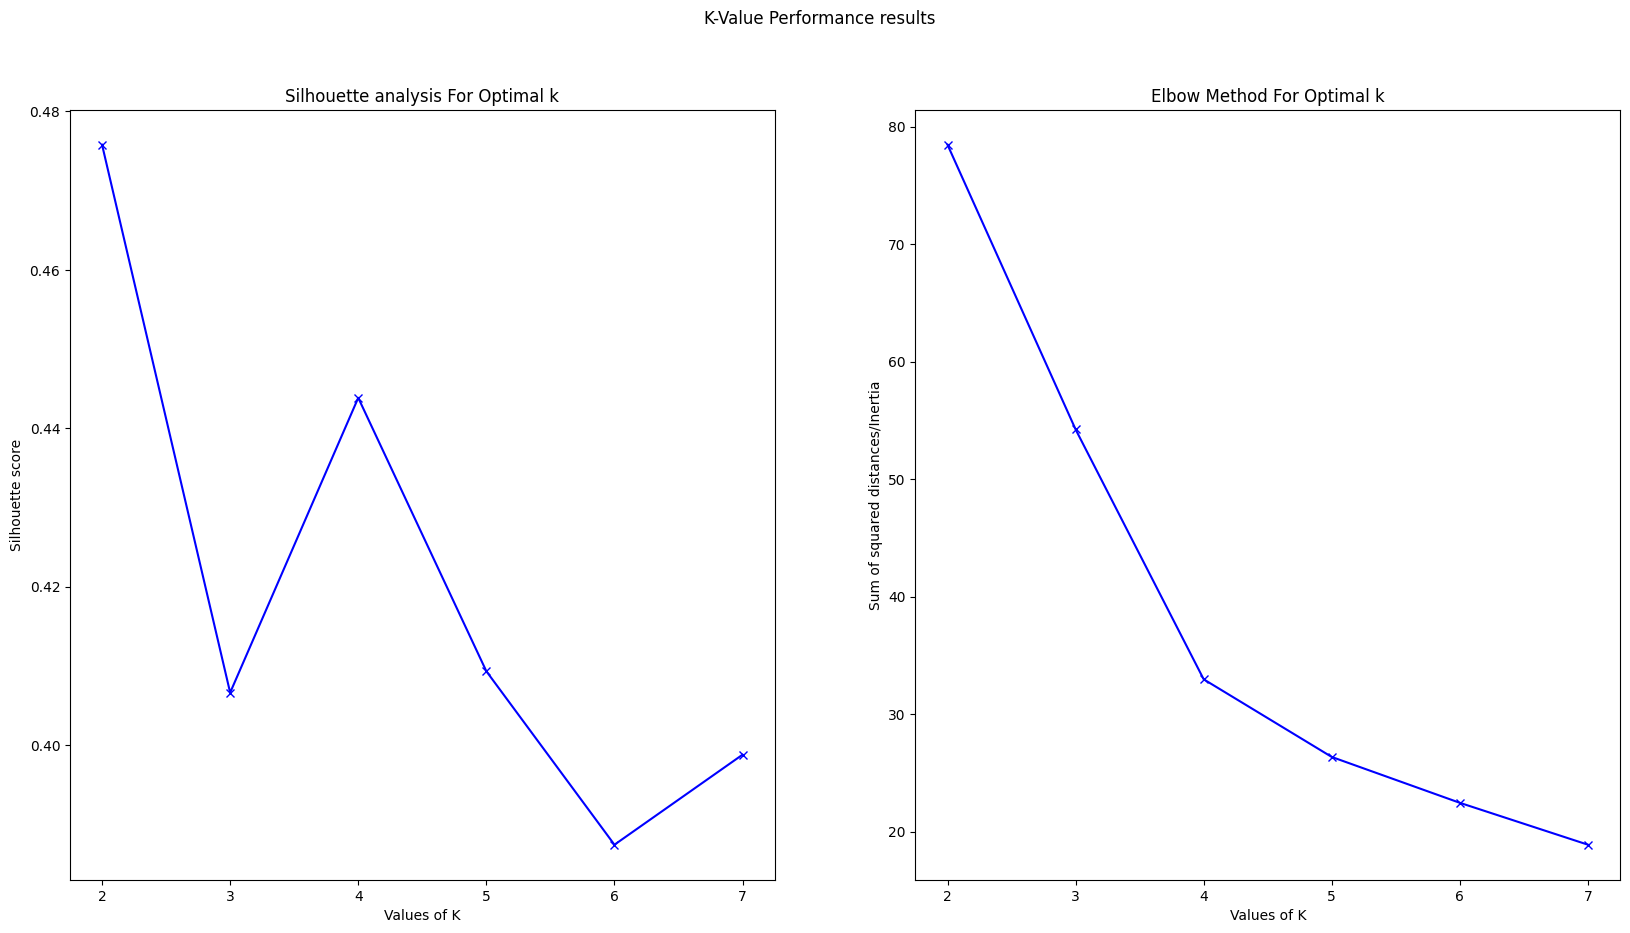

In [320]:
# silhouette and Elbow Method review

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
fig.suptitle('K-Value Performance results')
ax1.plot(k_vlaues,silhouette_avg,'bx-')
ax1.set_xlabel('Values of K') 
ax1.set_ylabel('Silhouette score') 
ax1.set_title('Silhouette analysis For Optimal k')

ax2.plot(k_vlaues,Sum_of_squared_distances,'bx-')
ax2.set_xlabel('Values of K') 
ax2.set_ylabel('Sum of squared distances/Inertia') 
ax2.set_title('Elbow Method For Optimal k')
plt.show()

The silhouette coefficient or silhouette score is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation). We see that the silhouette score is maximized at k = 2 but its second peak it at 4. In general the silhouette Method is used in combination with the Elbow Method for a more confident decision.

The elbow method calculate average distances to the centroid across all data points and we plot these points and find the point where the average distance from the centroid falls suddenly forming an “Elbow”. In the above plot, the elbow is at k=4 (i.e. Sum of squared distances falls suddenly) indicating the optimal k for this dataset is 4 (Arguably 5).

This suggests the best K value to select is 4.

## Consulsion on Clusters

Not knowing American geography well I cant' tell if my immedaite assumption of there being some geographical correaltion taking place is true or not. To test that theory I've tried to represent this data graphically on the US map.

Firstly Lets review the data on maps - before the clusters

(-127.6146362, -64.0610978, 23.253819649999997, 50.628669349999996)

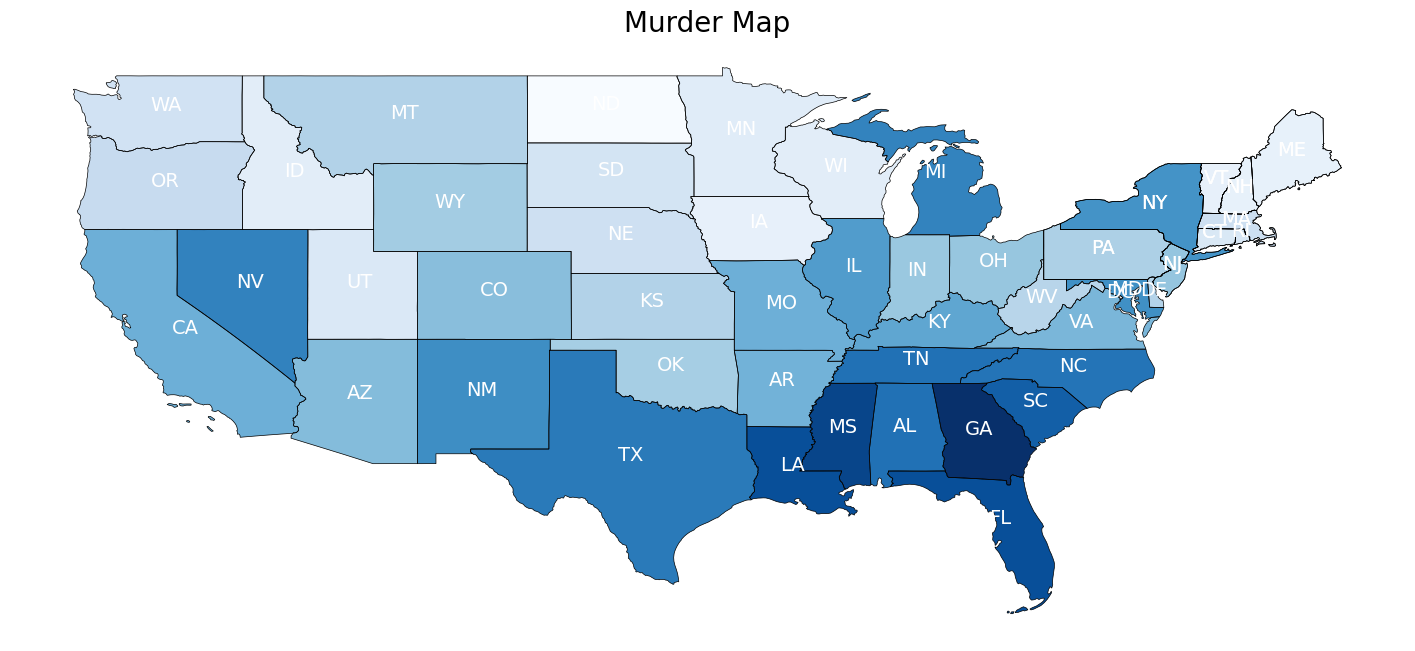

In [321]:
# lets load in the geodata for the states
states = geopandas.read_file('data/usa-states-census-2014.shp')
states.crs

# let extract the Murder/Assault/UrbanPop/Rape data and give it a custom colour range of blues, the higher the value the darkers the Blue
color_data = task_df['Murder'].values.tolist()

# create a color range for data range
blue_colours = matplotlib.cm.Blues
min_value=min(color_data)
max_value=max(color_data)
norm = matplotlib.colors.Normalize(vmin=min_value, vmax=max_value)
data_colours = [blue_colours(norm(value)) for value in color_data]

data_colours_dict = {}
for x in range(len(color_data)):
    data_colours_dict.update({color_data[x]:data_colours[x]})
    
us_boundary_map = states.boundary.plot(figsize=(18, 12), color='Black', linewidth=.5)
states.apply(lambda x: us_boundary_map.annotate(text=x.STUSPS, color='White', xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1)

plt.title("Murder Map", fontsize=20)

for state_name in states['NAME'].unique().tolist():
    if state_name in task_df.index.tolist():
        add_state = states[states['NAME'] == state_name]
        add_state.plot(ax=us_boundary_map,  color=data_colours_dict[task_df.loc[state_name]['Murder']])
plt.axis('off')

(-127.6146362, -64.0610978, 23.253819649999997, 50.628669349999996)

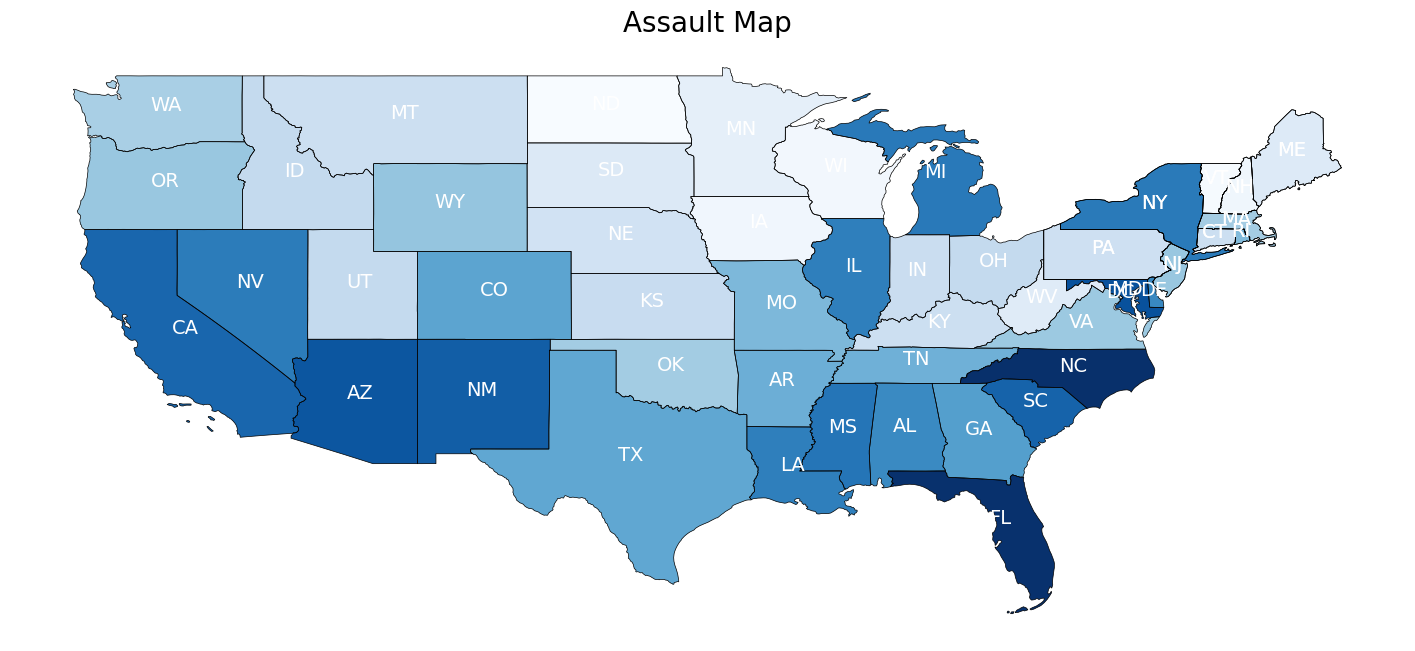

In [322]:
# let extract the Murder/Assault/UrbanPop/Rape data and give it a custom colour range of blues, the higher the value the darkers the Blue
color_data = task_df['Assault'].values.tolist()

# create a color range for data range
blue_colours = matplotlib.cm.Blues
min_value=min(color_data)
max_value=max(color_data)
norm = matplotlib.colors.Normalize(vmin=min_value, vmax=max_value)
data_colours = [blue_colours(norm(value)) for value in color_data]

data_colours_dict = {}
for x in range(len(color_data)):
    data_colours_dict.update({color_data[x]:data_colours[x]})
    
us_boundary_map = states.boundary.plot(figsize=(18, 12), color='Black', linewidth=.5)
states.apply(lambda x: us_boundary_map.annotate(text=x.STUSPS, color='White', xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1)
plt.title("Assault Map", fontsize=20)

for state_name in states['NAME'].unique().tolist():
    if state_name in task_df.index.tolist():
        add_state = states[states['NAME'] == state_name]
        add_state.plot(ax=us_boundary_map,  color=data_colours_dict[task_df.loc[state_name]['Assault']])
plt.axis('off')

(-127.6146362, -64.0610978, 23.253819649999997, 50.628669349999996)

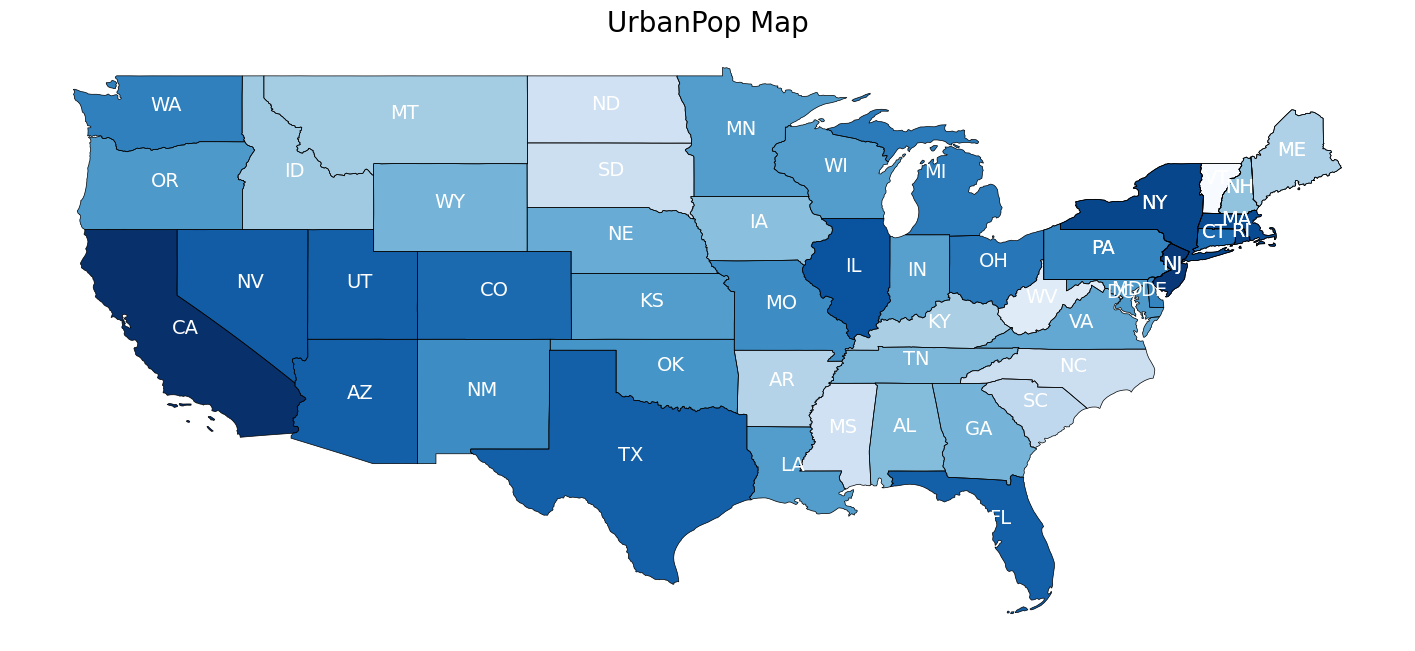

In [323]:
# let extract the Murder/Assault/UrbanPop/Rape data and give it a custom colour range of blues, the higher the value the darkers the Blue
color_data = task_df['UrbanPop'].values.tolist()

# create a color range for data range
blue_colours = matplotlib.cm.Blues
min_value=min(color_data)
max_value=max(color_data)
norm = matplotlib.colors.Normalize(vmin=min_value, vmax=max_value)
data_colours = [blue_colours(norm(value)) for value in color_data]

data_colours_dict = {}
for x in range(len(color_data)):
    data_colours_dict.update({color_data[x]:data_colours[x]})
    
us_boundary_map = states.boundary.plot(figsize=(18, 12), color='Black', linewidth=.5)
states.apply(lambda x: us_boundary_map.annotate(text=x.STUSPS, color='White', xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1)
plt.title("UrbanPop Map", fontsize=20)

for state_name in states['NAME'].unique().tolist():
    if state_name in task_df.index.tolist():
        add_state = states[states['NAME'] == state_name]
        add_state.plot(ax=us_boundary_map,  color=data_colours_dict[task_df.loc[state_name]['UrbanPop']])
plt.axis('off')

(-127.6146362, -64.0610978, 23.253819649999997, 50.628669349999996)

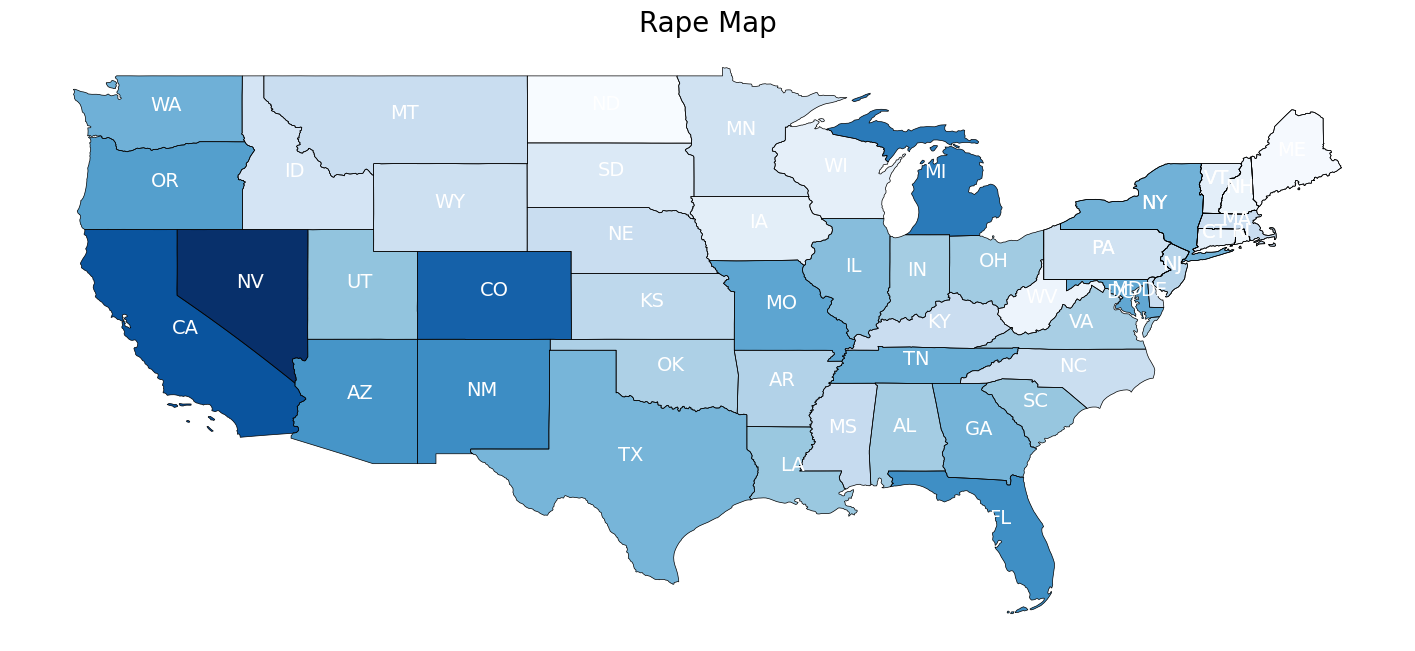

In [324]:
# let extract the Murder/Assault/UrbanPop/Rape data and give it a custom colour range of blues, the higher the value the darkers the Blue
color_data = task_df['Rape'].values.tolist()

# create a color range for data range
blue_colours = matplotlib.cm.Blues
min_value=min(color_data)
max_value=max(color_data)
norm = matplotlib.colors.Normalize(vmin=min_value, vmax=max_value)
data_colours = [blue_colours(norm(value)) for value in color_data]

data_colours_dict = {}
for x in range(len(color_data)):
    data_colours_dict.update({color_data[x]:data_colours[x]})
    
us_boundary_map = states.boundary.plot(figsize=(18, 12), color='Black', linewidth=.5)
states.apply(lambda x: us_boundary_map.annotate(text=x.STUSPS, color='White', xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1)
plt.title("Rape Map", fontsize=20)

for state_name in states['NAME'].unique().tolist():
    if state_name in task_df.index.tolist():
        add_state = states[states['NAME'] == state_name]
        add_state.plot(ax=us_boundary_map,  color=data_colours_dict[task_df.loc[state_name]['Rape']])
plt.axis('off')

Now lets see where the clusters fall

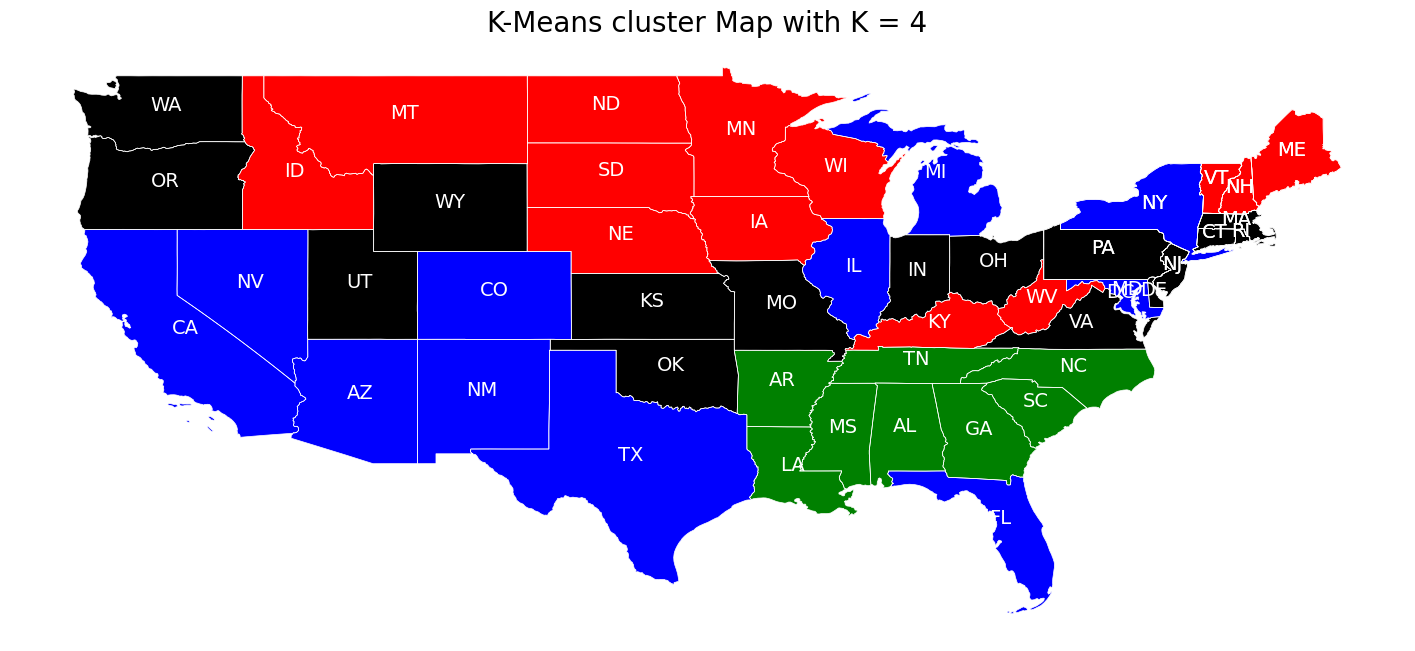

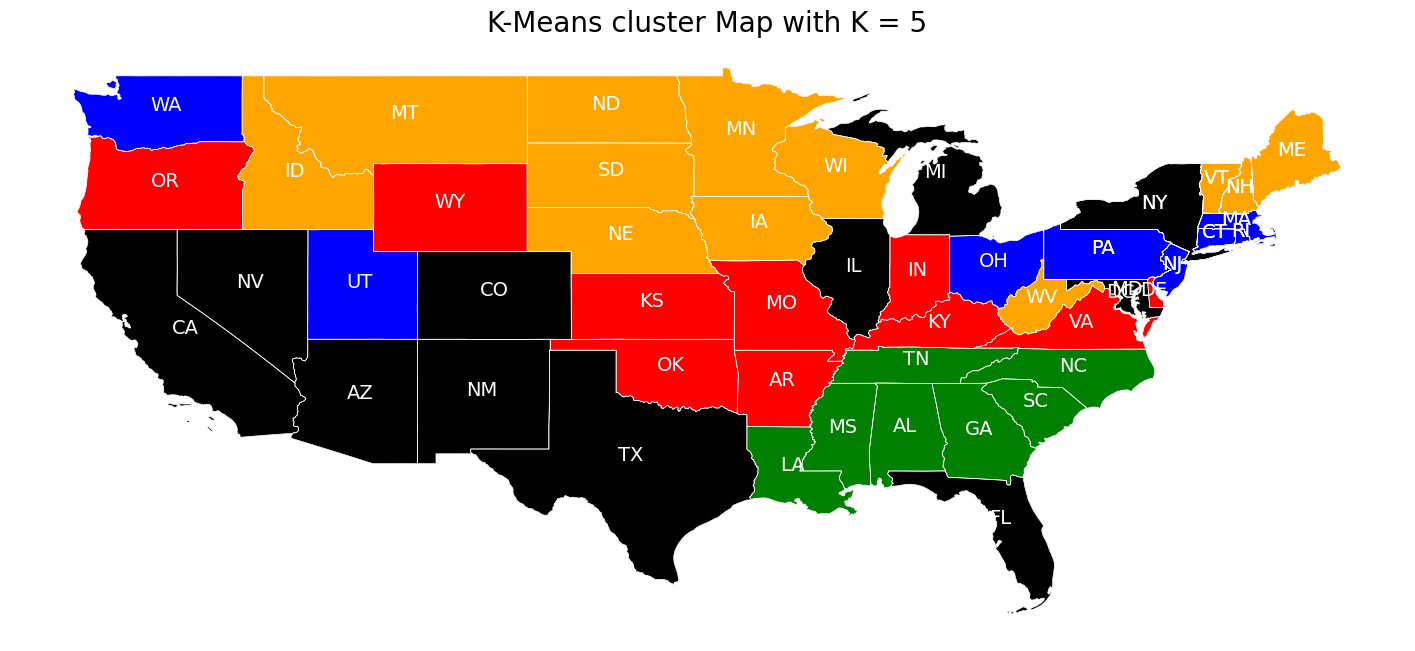

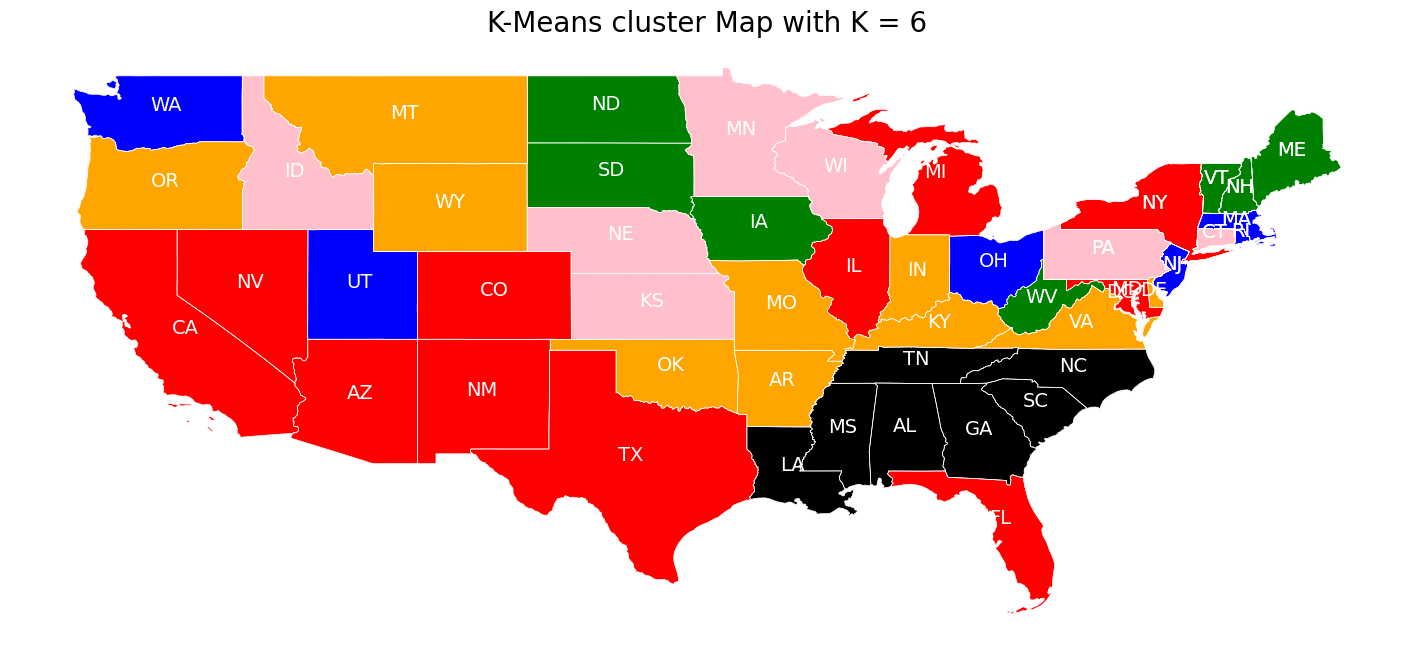

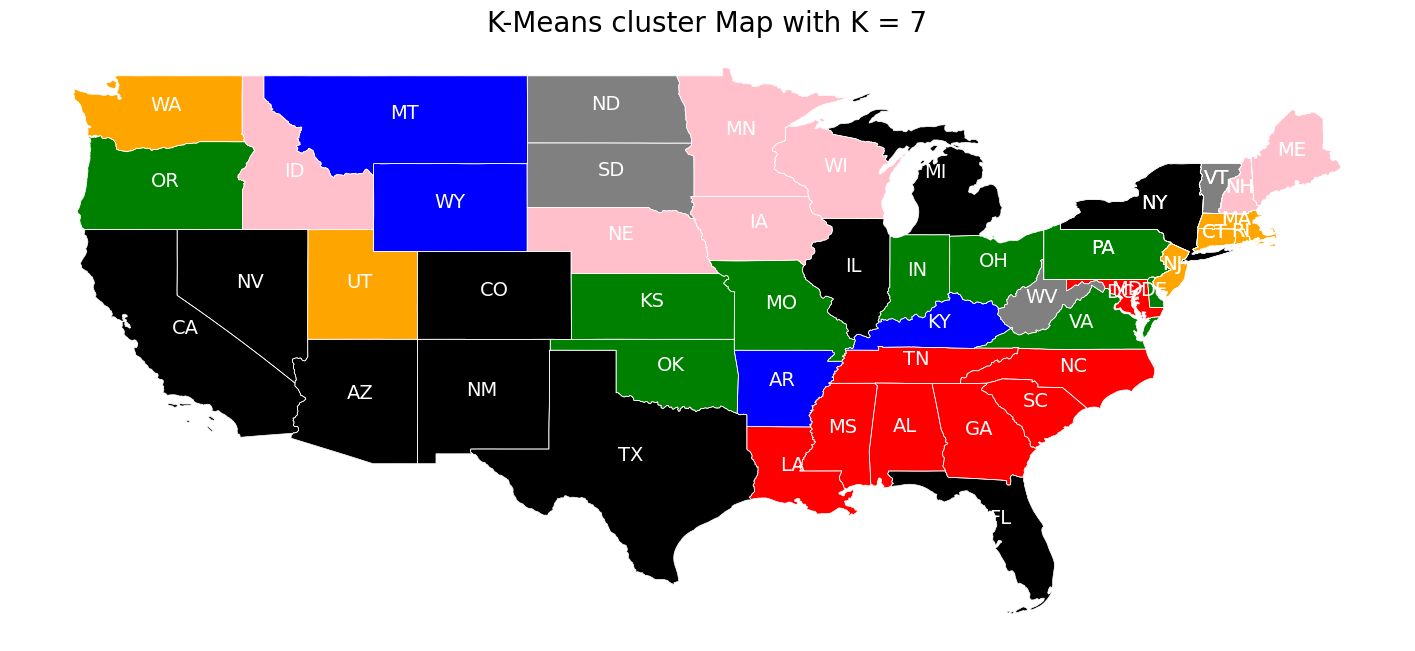

In [325]:
# Update list of K-Values to test.
k_vlaues = [4,5,6,7]

# create maps of the results
for k in k_vlaues:  
    us_boundary_map = states.boundary.plot(figsize=(18, 12), color='White', linewidth=.5)
    states.apply(lambda x: us_boundary_map.annotate(text=x.STUSPS, color='White', xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1)
    plt.title(f"K-Means cluster Map with K = {k}", fontsize=20)

    for i in range(1,k+1):
        group_states = list(clusters_dict[k][i])
        map_group = states[states['NAME'].isin(group_states)]
        map_group.plot(ax=us_boundary_map,  color=colour_options[i-1])
        plt.axis('off')


From reviewing this data its clear to my limited known of american economics, poplualtion density and geographic make up that the clusters identified in the k-means model with a K value of 4 show almost logical divide forming clusters of regions: South West, South East, North and Middle largely reflecting the population density map.

This would make sense such that florida, Texas and the South to Mid West are known for high densitiy, high economic areas, that are baron/tough to farm (but for cattle in Texas). Whereas The North is almost the polar opposite to this forming its own cluster of data of low population density, largely argricultural land. the south East is known for poultry farming, hot humid environment with few coastal population spikes but inland similarly low denisity population. The middle however is the one veriable that is where the most change takes place through out the changes in K-Vlaue.

This would correlate with same logic that crime rates are genrally higher in higher density areas (as suggest by the PCA analysis) and larger economic areas, attract more people. 

In all 4 plots, K values of 4,5,6 and 7 the South West and East clusters basically don't change. However the Middle and North get increasingly separated into bands moving north with some areas of the north west sharing trends of these bands. geographically the Rockie Mountain range separates the north west corner from the rest of the north and its coastal cities are famously large and again high density prosperus areas.

In conclusion I believe that the K vlaue of 4 gives clearest picture of the clusters the data.

# Conclusion

 The Hierarchical and K-means cluster modelling both gave a best fit of 4 clusters. The maps showsed there was geographically coorelation in these clusters  and as such the four clusters are made up the states:

In [326]:
# Groups - translate to readable names
for i,states in clusters_dict[4].items():
    print(f"Cluster {i}:\n{', '.join(states)}\n")

Cluster 1:
Arizona, California, Colorado, Florida, Illinois, Maryland, Michigan, Nevada, New Mexico, New York, Texas

Cluster 2:
Idaho, Iowa, Kentucky, Maine, Minnesota, Montana, Nebraska, New Hampshire, North Dakota, South Dakota, Vermont, West Virginia, Wisconsin

Cluster 3:
Alabama, Alaska, Arkansas, Georgia, Louisiana, Mississippi, North Carolina, South Carolina, Tennessee

Cluster 4:
Connecticut, Delaware, Hawaii, Indiana, Kansas, Massachusetts, Missouri, New Jersey, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, Utah, Virginia, Washington, Wyoming

